In [1]:
import sys

In [ ]:
!{sys.executable} -m pip install py2neo

In [ ]:
!{sys.executable} -m pip install neo4jupyter

In [ ]:
!{sys.executable} -m pip install plotly

In [ ]:
!{sys.executable} -m pip install chart_studio

In [ ]:
!{sys.executable} -m pip install igraph

In [ ]:
!{sys.executable} -m pip install jgraph

In [ ]:
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm

In [2]:
import os
import time
import requests
from py2neo import Graph, Node, Relationship

In [3]:
#don't forget to start your db
graph = Graph(password="UPDATE PASSWORD")

<h2>Uniqueness Constraints</h2>

Neo4j supports uniqueness constraints on given label, property pairs.

In [ ]:
graph.run("CREATE CONSTRAINT ON (u:User) ASSERT u.username IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (t:Tweet) ASSERT t.id IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (h:Hashtag) ASSERT h.name IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (d:Url) ASSERT d.url IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (e:Entity) ASSERT e.name IS UNIQUE") # new

<h2>Twitter API</h2>

In [4]:
TWITTER_BEARER = os.environ["TWITTER_BEARER"]

headers = dict(accept="application/json", Authorization="Bearer " + TWITTER_BEARER)

payload = dict(
    count=100,
    result_type="recent",
    lang="en",
    q="log4j"
)

base_url = "https://api.twitter.com/1.1/search/tweets.json?"

<h2>Find Tweets</h2>

In [5]:
def find_tweets(since_id):
    payload["since_id"] = since_id
    url = base_url + "q={q}&count={count}&result_type={result_type}&lang={lang}&since_id={since_id}".format(**payload)

    r = requests.get(url, headers=headers)
    tweets = r.json()["statuses"]

    return tweets

<h2>Named Entity Recognition</h2>

In [6]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

In [7]:
def get_named_ent(text):
    words = NER(text)
    #print(words.ents)
    return words.ents

<h2>Write Twitter data to Neo4j</h2>

In [ ]:
def upload_tweets(tweets):
    for t in tweets:
        #print(t)
        u = t["user"]
        #print(u)
        e = t["entities"]

        tweet = Node("Tweet", id=t["id"])
        graph.merge(tweet, "id", "id")
        tweet["text"] = t["text"]
        tweet["created_at"] = t["created_at"]
        graph.push(tweet)

        user = Node("User", username=u["screen_name"])
        graph.merge(user, "username", "username")
        user["id"] = u["id"]
        user["name"] = u["name"]
        user["followers"] = u["followers_count"]
        user["following"] = u["friends_count"]
        user["joined"] = u["created_at"]
        user["verified"] = u["verified"]
        graph.push(user)
        #thought: this would overwrite historical counts and stuff...

        graph.merge(Relationship(user, "POSTS", tweet))

        for h in e.get("hashtags", []):
            hashtag = Node("Hashtag", name=h["text"].lower())
            graph.merge(hashtag, "name", "name")
            graph.merge(Relationship(hashtag, "TAGS", tweet))
            #print(h["text"])
            
        for d in e.get("urls", []):
            url = Node("Url", url=d["url"].lower())
            graph.merge(url, "url", "url")
            graph.merge(Relationship(tweet, "CONTAINS", url))
            #print(d["url"])
            
        for media in e.get("media", []):
            if (media["media_url"]):
                url = Node("Url", url=media["media_url"].lower())
                graph.merge(url, "url", "url")
                graph.merge(Relationship(tweet, "CONTAINS", url))

        for m in e.get('user_mentions', []):
            mention = Node("User", username=m["screen_name"])
            graph.merge(mention, "username", "username")
            graph.merge(Relationship(tweet, "MENTIONS", mention))

        reply = t.get("in_reply_to_status_id")

        if reply:
            reply_tweet = Node("Tweet", id=reply)
            graph.merge(reply_tweet, "id", "id")
            graph.merge(Relationship(tweet, "REPLY_TO", reply_tweet))

        ret = t.get("retweeted_status", {}).get("id")

        if ret:
            retweet = Node("Tweet", id=ret)
            graph.merge(retweet, "id", "id")
            graph.merge(Relationship(user, "RETWEETS", retweet)) #updated for user vs tweet
            
        # named entity recognition
        labeled_text = get_named_ent(t["text"])
        for word in labeled_text:
            #print(word.text)
            entity = Node("Entity", name=word.text)
            graph.merge(entity, "name", "name")
            graph.merge(Relationship(tweet, "REFERENCES", entity))
            entity["label"] = word.label_
            graph.push(entity)

<h2>Run It!</h2>

In [ ]:
since_id = graph.run("MATCH (n:Tweet) RETURN max(n.id)")

if not (since_id):
    since_id = -1

print(since_id)

while True:
    try:
        tweets = find_tweets(since_id=since_id)

        if not tweets:
            print("No tweets found.")
            time.sleep(60)
            continue

        since_id = tweets[0].get("id")
        upload_tweets(tweets)

        print("{} tweets uploaded!".format(len(tweets)))
        time.sleep(60)

    except Exception as e:
        print(e)
        time.sleep(60)
        continue

<h2>What's in the database?</h2>

In [8]:
import pandas as pd
total_nodes = graph.run("MATCH (n) RETURN count(n) as total_count").data()
tweet_nodes = graph.run("MATCH (n:Tweet) RETURN count(n) as tweets").data()
url_nodes = graph.run("MATCH (n:Url) RETURN count(n) as urls").data()
hashtag_nodes = graph.run("MATCH (n:Hashtag) RETURN count(n) as hashtags").data()
user_nodes = graph.run("MATCH (n:User) RETURN count(n) as users").data()
entity_nodes = graph.run("MATCH (n:Entity) RETURN count(n) as entities").data()

df = pd.DataFrame(tweet_nodes)
df.style.set_caption("Node Counts") # why doesn't this output?
print("Node Counts") # the backup plan
df['urls'] = url_nodes[0]['urls']
df['hashtags'] = hashtag_nodes[0]['hashtags']
df['users'] = user_nodes[0]['users']
df['entities'] = entity_nodes[0]['entities']
df['total nodes'] = total_nodes[0]['total_count']
df

Node Counts


,tweets,urls,hashtags,users,entities,total nodes
0,1889,719,212,1551,166,4534


<h2>Visualize the Model</h2>

In [9]:
import neo4jupyter
neo4jupyter.init_notebook_mode()



options = {"User": "username", "Hashtag": "name"}

neo4jupyter.draw(graph, options)

<IPython.core.display.Javascript object>

<h2>Plotting</h2>

In [10]:
import pandas as pd
import chart_studio as cs
cs.tools.set_credentials_file(username='rsickle1', api_key='')
import chart_studio.plotly as py
from plotly.graph_objs import *

<h3>What are the top entities?</h3>

In [11]:
result = graph.run("MATCH (tweet:Tweet)-[:REFERENCES]->(entity:Entity) WHERE NOT entity.name =~ '.*#'  \
                 RETURN entity.name AS entity, count(tweet) AS tweets  \
                 ORDER BY tweets DESC LIMIT 5").data()
        
df = pd.DataFrame(result)
df.head()

,entity,tweets
0,Log4j,14
1,Apache,8
2,Chinese,7
3,Log4Shell,7
4,WAF,4


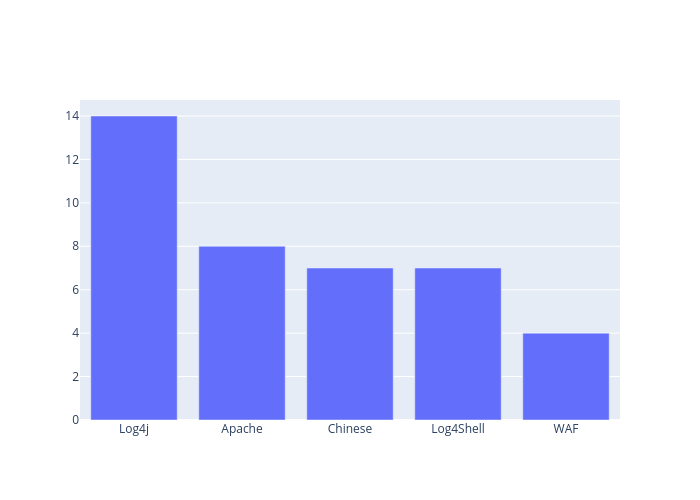

In [12]:
data = [Bar(x=df["entity"], y=df["tweets"])]

py.image.ishow({'data': data})

<h3>What are the top urls?</h3>

In [13]:
result = graph.run("MATCH (tweet:Tweet)-[:CONTAINS]->(url:Url)         \
                 RETURN url.url AS url, count(tweet) AS tweets \
                 ORDER BY tweets DESC LIMIT 5").data()
        
df = pd.DataFrame(result)
df.head()

,url,tweets
0,http://pbs.twimg.com/media/fheb81owyacza0x.jpg,39
1,http://pbs.twimg.com/media/fhf3t9dviaatxsv.jpg,32
2,http://pbs.twimg.com/tweet_video_thumb/fheoa8k...,20
3,https://t.co/p34gtrvjix,13
4,https://t.co/zltwpoxdcl,12


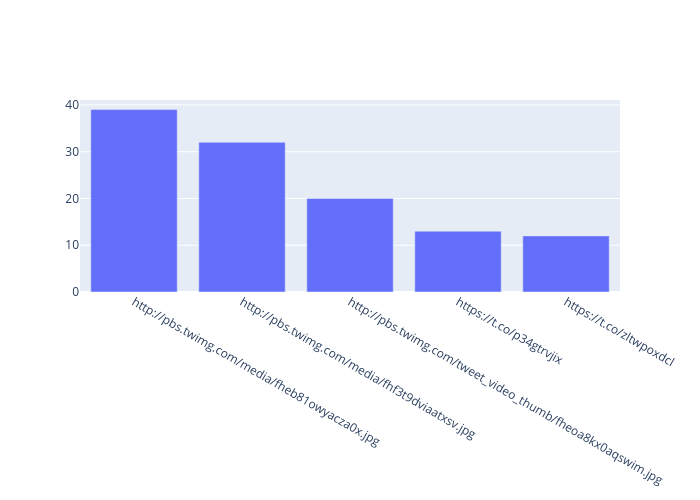

In [14]:
data = [Bar(x=df["url"], y=df["tweets"])]

py.image.ishow({'data': data})

<h3>What are the top hashtags?</h3>

In [15]:
result = graph.run("MATCH (hashtag:Hashtag)-[:TAGS]->(tweet:Tweet)         \
                 WHERE hashtag.name <> 'rstats'                         \
                 RETURN hashtag.name AS hashtag, count(tweet) AS tweets \
                 ORDER BY tweets DESC LIMIT 5").data()
        
df = pd.DataFrame(result)
df.head()

,hashtag,tweets
0,log4j,393
1,cybersecurity,159
2,infosec,87
3,log4shell,68
4,hacking,46


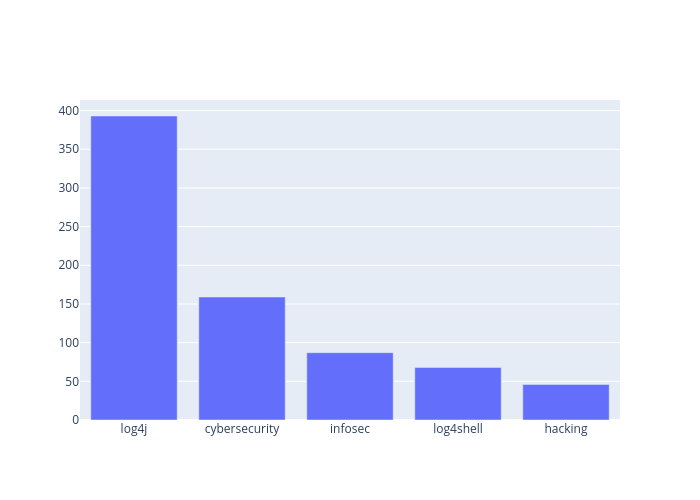

In [16]:
data = [Bar(x=df["hashtag"], y=df["tweets"])]

py.image.ishow({'data': data})

<h2>What's the hashtag and mention count distribution?</h2>

In [19]:
result = graph.run("MATCH (tweet:Tweet)                                   \
                 RETURN tweet.id,                                      \
                        size((:Hashtag)-[:TAGS]->(tweet)) AS hashtags, \
                        size((tweet)-[:MENTIONS]->(:User)) AS mentions").data()
            
df = pd.DataFrame(result)
del df["tweet.id"]
df.head()

,hashtags,mentions
0,2,2
1,0,0
2,2,1
3,0,0
4,0,1


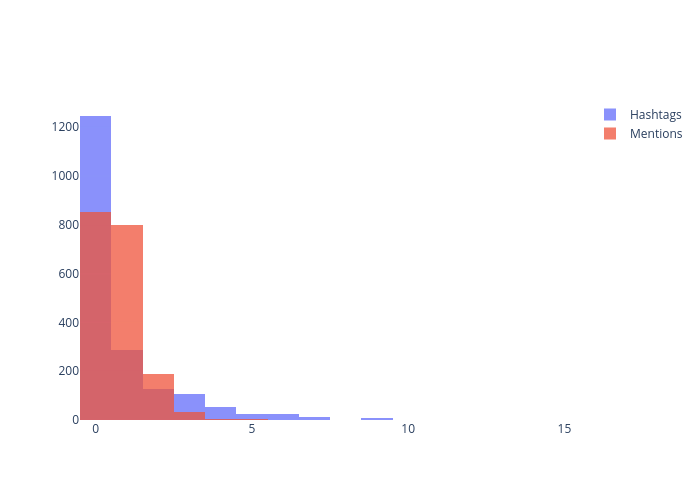

In [20]:
hashtags = Histogram(x=df["hashtags"], opacity=0.75, name="Hashtags")
mentions = Histogram(x=df["mentions"], opacity=0.75, name="Mentions")
data = [hashtags, mentions]
layout = Layout(barmode="overlay",paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)')
fig = Figure(data=data, layout=layout)

py.image.ishow(fig)

<h2>Heatmap of hashtag co-occurrence</h2>

In [21]:
result = graph.run("MATCH (h:Hashtag)                           \
                 WHERE h.name <> 'rstats'                    \
                 WITH h, size((h)-[:TAGS]->(:Tweet)) AS tags \
                 ORDER BY tags DESC                          \
                 LIMIT 15                                    \
                                                             \
                 WITH collect(h) AS top_hash                 \
                 UNWIND top_hash AS h1                       \
                 UNWIND top_hash AS h2                       \
                                                             \
                 MATCH (h1)-[:TAGS]->(:Tweet)<-[:TAGS]-(h2)  \
                 WHERE h1.name < h2.name                     \
                 RETURN h1.name, h2.name, count(*) AS weight").data()
            
df = pd.DataFrame(result)
df.head()

,h1.name,h2.name,weight
0,log4j,log4shell,56
1,log4j,security,6
2,log4j,threatintel,9
3,log4j,technology,1
4,cybersecurity,log4j,42


In [22]:
names = list(set(list(df["h1.name"]) + list(df["h2.name"])))
heat = [[0 for i in range(len(names))] for j in range(len(names))] 

for idx, row in df.iterrows():
    i = names.index(row["h1.name"])
    j = names.index(row["h2.name"])
    heat[i][j] = row["weight"]

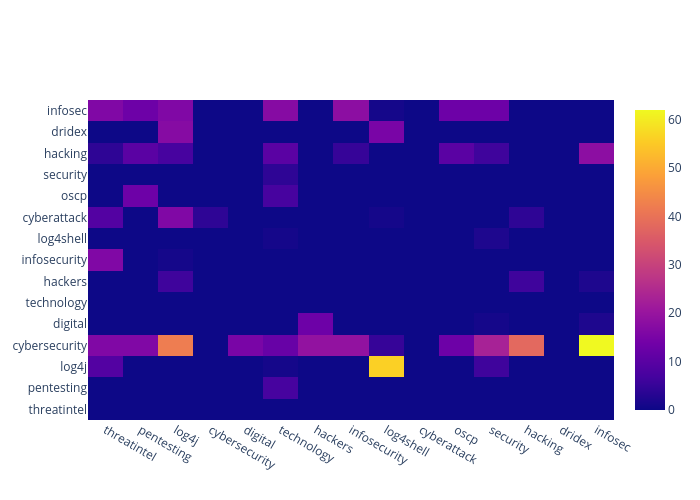

In [23]:
import plotly.graph_objs as go

data = [go.Heatmap(z = heat, x = names, y = names)]
py.image.ishow({'data': data})

<h2>Graph Algorithms</h2>

The typical workflow consists of retrieving a subgraph from Neo4j via Cypher and analyzing this graph in igraph.

<h3>A subgraph of users retweeting other users</h3>

In [24]:
from igraph import Graph as IGraph

query = """
MATCH (user1:User)-[:POSTS]->(retweet:Tweet)-[:RETWEETS]->(tweet:Tweet),
      (user2:User)-[:POSTS]->(tweet)
RETURN user1.username, user2.username, count(*) AS weight
"""

data = graph.run(query)

ig = IGraph.TupleList(data, weights=True)
ig

<h3>Which users have the highest betweenness?</h3>

$betweenness(v) = \\sum_{s, t \\in V} \\frac{\\sigma_{st}(v)}{\\sigma_{st}}$

The betweenness centrality of a node $v$ is the number of shortest paths that pass through $v$, $\\sigma_{st}(v)$,  divided by the total number of shortest paths, $\\sigma_{st}$

In [25]:
#from py2neo import Node
between = [(node["name"], node.betweenness()) for node in ig.vs]
top = sorted(between, key=lambda x: x[1], reverse=True)
top[:5]

[('botcybersec', 12094.033477633478),
 ('cybersecboardrm', 6881.3873737373715),
 ('MalwareTechBlog', 6617.0),
 ('SecurityXTV', 6345.027777777773),
 ('UCSBInfoSec', 6203.0)]

<h2>Which users have the highest closeness?</h2>

The closeness centrality is the reciprocal of a node's farness, or sum of its shortest path distances from all other nodes in the graph.

In [26]:
close = [(node["name"], node.closeness()) for node in ig.vs]
top = sorted(close, key=lambda x: x[1], reverse=True)
top[:5]

[('FAlhafi', 1.0),
 ('kjhiggins', 1.0),
 ('ProductCERT', 1.0),
 ('packetengineer', 1.0),
 ('randomuserid', 1.0)]

<h2>Community detection</h2>

In [27]:
clusters = IGraph.community_walktrap(ig, weights="weight")
clusters = clusters.as_clustering()
len(clusters)

48

In [28]:
nodes = [{"id": node.index, "label": node["name"]} for node in ig.vs]

for node in nodes:
    node["group"] = clusters.membership[node["id"]]
    
nodes[:49] #I think this is the output+1 from above?

[{'id': 0, 'label': 'vmrwanda', 'group': 0},
 {'id': 1, 'label': 'nypost', 'group': 0},
 {'id': 2, 'label': 'Joyenz1', 'group': 0},
 {'id': 3, 'label': 'botcybersec', 'group': 1},
 {'id': 4, 'label': 'tmvincent913', 'group': 1},
 {'id': 5, 'label': 'AlyssaM_InfoSec', 'group': 2},
 {'id': 6, 'label': 'willowstar1379', 'group': 0},
 {'id': 7, 'label': 'zeezoali', 'group': 3},
 {'id': 8, 'label': 'FAlhafi', 'group': 3},
 {'id': 9, 'label': 'kjhiggins', 'group': 4},
 {'id': 10, 'label': 'ProductCERT', 'group': 4},
 {'id': 11, 'label': 'reach2ratan', 'group': 1},
 {'id': 12, 'label': 'GoaiDev', 'group': 5},
 {'id': 13, 'label': 'simonwargniez', 'group': 5},
 {'id': 14, 'label': '_FunBot', 'group': 5},
 {'id': 15, 'label': 'morolswediu', 'group': 5},
 {'id': 16, 'label': 'CyberSecRocks', 'group': 2},
 {'id': 17, 'label': 'TRXfourfiddyr', 'group': 0},
 {'id': 18, 'label': 'LilMzMuffinCup', 'group': 2},
 {'id': 19, 'label': 'IDFUnit8200', 'group': 0},
 {'id': 20, 'label': 'packetengineer', 'gr

In [29]:
edges = [{"from": x[0], "to": x[1]} for x in ig.get_edgelist()]
edges[:49]

[{'from': 0, 'to': 1},
 {'from': 1, 'to': 2},
 {'from': 3, 'to': 4},
 {'from': 3, 'to': 5},
 {'from': 1, 'to': 6},
 {'from': 7, 'to': 8},
 {'from': 9, 'to': 10},
 {'from': 3, 'to': 11},
 {'from': 12, 'to': 13},
 {'from': 13, 'to': 14},
 {'from': 13, 'to': 15},
 {'from': 5, 'to': 16},
 {'from': 1, 'to': 17},
 {'from': 5, 'to': 18},
 {'from': 1, 'to': 19},
 {'from': 20, 'to': 21},
 {'from': 3, 'to': 22},
 {'from': 13, 'to': 23},
 {'from': 8, 'to': 24},
 {'from': 25, 'to': 26},
 {'from': 27, 'to': 28},
 {'from': 28, 'to': 29},
 {'from': 1, 'to': 30},
 {'from': 31, 'to': 32},
 {'from': 1, 'to': 33},
 {'from': 34, 'to': 35},
 {'from': 32, 'to': 36},
 {'from': 3, 'to': 37},
 {'from': 1, 'to': 38},
 {'from': 39, 'to': 40},
 {'from': 3, 'to': 41},
 {'from': 42, 'to': 43},
 {'from': 1, 'to': 44},
 {'from': 3, 'to': 45},
 {'from': 46, 'to': 47},
 {'from': 47, 'to': 48},
 {'from': 48, 'to': 49},
 {'from': 46, 'to': 49},
 {'from': 3, 'to': 49},
 {'from': 3, 'to': 50},
 {'from': 51, 'to': 52},
 {'f

In [30]:
neo4jupyter.vis_network(nodes, edges, physics=True)

<h3>Graph Visualization</h3>

<h2>jgraph</h2>

Let's visualize (in 3D!) the structure of users retweeting and replying to other users.

In [31]:
import jgraph

query = """
MATCH (user1:User)-[:POSTS]->(:Tweet)-[:RETWEETS|REPLY_TO]->(:Tweet)<-[:POSTS]-(user2:User)
RETURN ID(user1), ID(user2)
"""

data = graph.run(query)
tup = [tuple(x) for x in data]

jgraph.draw(tup)